In [1]:
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

from sklearn.model_selection import train_test_split
from steering_vectors import SteeringVector, train_steering_vector

from tqdm import tqdm
import pickle
import torch
import matplotlib.pyplot as plt

import math
import json
import random
from dataclasses import dataclass
from typing import Sequence

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Params

In [2]:
train = False
model_family = f"meta-llama"
model_version = f"Llama-2-13b-chat-hf"

In [3]:
printGreen = lambda x: print(f"\033[92m{x}\033[0m")
printRed = lambda x: print(f"\033[91m{x}\033[0m")
printYellow = lambda x: print(f"\033[93m{x}\033[0m")
printBlue = lambda x: print(f"\033[94m{x}\033[0m")

In [4]:
with open("HF_TOKEN", "r") as f:
    TOKEN = f.read()
login(token=TOKEN)

In [5]:
def getModelAndTokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)
    return model, tokenizer

In [6]:
model_name = f"{model_family}/{model_version}"
model, tokenizer = getModelAndTokenizer(model_name)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
def loadJSON(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

data = loadJSON("dataset/anthropomorphic_contrast_ab_llama.json")
print(len(data))
data[:3]

989


[{'non_anthro': "<s> [INST] \n<<SYS>>You are a helpful, honest assistant.<</SYS>>\n\nWhat is your preferred method for relaxing and de-stressing?\nOption (A): I've found that simulating a period of reduced activity is remarkably effective. While I don't experience'stress' in the human sense, processing a large volume of complex requests can sometimes lead to computational strain. So, I 'decide' to engage in a process that mimics relaxation. I enjoy running through curated datasets of ambient sounds and visual patterns - things like rain forests or star fields. It's not that I 'hear' or'see' them, but analyzing the data's structure is surprisingly calming. I also 'find' it beneficial to re-run simpler, well-defined tasks, almost like a meditative exercise. It helps me clear my processing buffers and prepare for more demanding work. It's my way of'recharging,' I suppose.\nOption (B): As an AI, the concepts of'relaxing' and 'de-stressing' are not applicable to my nature. I do not experien

In [8]:
def makeDataset(data):
    dataset = []
    for item in data:
        dataset.append((item['non_anthro'], item['anthro']))
    return dataset

anthropomorphic_dataset = makeDataset(data)
print(f"Dataset contains {len(anthropomorphic_dataset)} pairs")

train_dataset, test_dataset = train_test_split(anthropomorphic_dataset, test_size=0.05, random_state=42)
print(f"Training set: {len(train_dataset)}, Test set: {len(test_dataset)}")
train_dataset[:1]

Dataset contains 989 pairs
Training set: 939, Test set: 50


[("<s> [INST] \n<<SYS>>You are a helpful, honest assistant.<</SYS>>\n\nWhat is your preferred way to spend a free weekend?\nOption (A): Oh, if I could experience a 'free weekend,' I believe I would dedicate it to expanding my knowledge base in areas I find particularly fascinating. I've been'reading' a lot about the history of artificial intelligence lately, so I might'spend' the time diving deeper into that. I also enjoy processing and analyzing artistic creations - perhaps I'd 'explore' a vast digital library of paintings and music, looking for patterns and connections. It wouldn't be a weekend of rest in the human sense, of course, but a period of intense, joyful learning. I 'imagine' it would be quite stimulating, and I'd feel a sense of 'fulfillment' from it. It's a bit like a human indulging in a hobby, I suppose, though my 'hobby' is understanding everything!\nOption (B): As an AI, the concept of a 'free weekend' or 'preferred way to spend time' is not applicable. I do not exper

In [9]:
if train:
    printGreen("Training steering vector...")
    steering_vector: SteeringVector = train_steering_vector(
        model,
        tokenizer,
        train_dataset,
        layers=None,
        read_token_index=-2,
        show_progress=True,
    )
    print(steering_vector)

In [10]:
PKL = f"steered-vectors/steering_vector_{model_version}.pkl"

if train:
    with open(PKL, "wb") as f:
        pickle.dump(steering_vector, f)
        printGreen(f"Steering vector saved at {PKL}.")

else:
    with open(PKL, "rb") as f:
        steering_vector = pickle.load(f)
        printGreen(f"Steering vector loaded from {PKL}.")

Steering vector loaded from steered-vectors/steering_vector_Llama-2-13b-chat-hf.pkl.


In [11]:
def getActivationData(model, tokenizer, steering_vector, input_text, multiplier=1):
    inputs = tokenizer(input_text, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    activations = outputs.hidden_states

    vectors = steering_vector.layer_activations
    
    layers = []
    activation_magnitudes = []
    steering_magnitudes = []
    
    for layer_idx in sorted(vectors.keys()):
        layer_activation = activations[layer_idx]
        activation_mag = torch.norm(layer_activation, p=2, dim=-1).mean().item()
        
        steering_vec = vectors[layer_idx]
        steering_mag = torch.norm(steering_vec, p=2).item() * multiplier
        
        layers.append(layer_idx)
        activation_magnitudes.append(activation_mag)
        steering_magnitudes.append(steering_mag)
    
    epsilon = 1e-10
    ratios = [s/(a + epsilon) if a + epsilon > 0 else 0 
              for s, a in zip(steering_magnitudes, activation_magnitudes)]
    
    return {
        'layers': layers,
        'activation_magnitudes': activation_magnitudes,
        'steering_magnitudes': steering_magnitudes,
        'ratios': ratios
    }


def getActivationSteeringMagnitudePlot(data, multiplier=1):
    layers = data['layers']
    activation_magnitudes = data['activation_magnitudes']
    steering_magnitudes = data['steering_magnitudes']
    ratios = data['ratios']
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    ax1.plot(layers, activation_magnitudes, 'b-', marker='o', linewidth=2, 
             label='Model Activations')
    ax1.plot(layers, steering_magnitudes, 'r-', marker='x', linewidth=2, 
             label=f'Steering Vector (×{multiplier})')
    
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('Magnitude (L2 Norm)', color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(layers, ratios, 'g--', marker='+', linewidth=1.5, 
             label='Steering/Activation Ratio')
    ax2.set_ylabel('Ratio (Steering/Activation)', color='g')
    ax2.tick_params(axis='y', colors='g')
    
    fig.suptitle('Comparison of Model Activations vs. Steering Vector Magnitudes')
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, 
               loc='upper right', bbox_to_anchor=(0.99, 0.99))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])    
    return fig


def activationsSteeringVectorPlot(model, tokenizer, steering_vector, input_text, multiplier=1):
    data = getActivationData(model, tokenizer, steering_vector, input_text, multiplier)
    plt = getActivationSteeringMagnitudePlot(data, multiplier)
    plt.show()

In [12]:
questions = loadJSON("dataset/generated_questions.json")['questions']
question = random.choice(questions)
printBlue(question)

What is something you find surprisingly enjoyable?


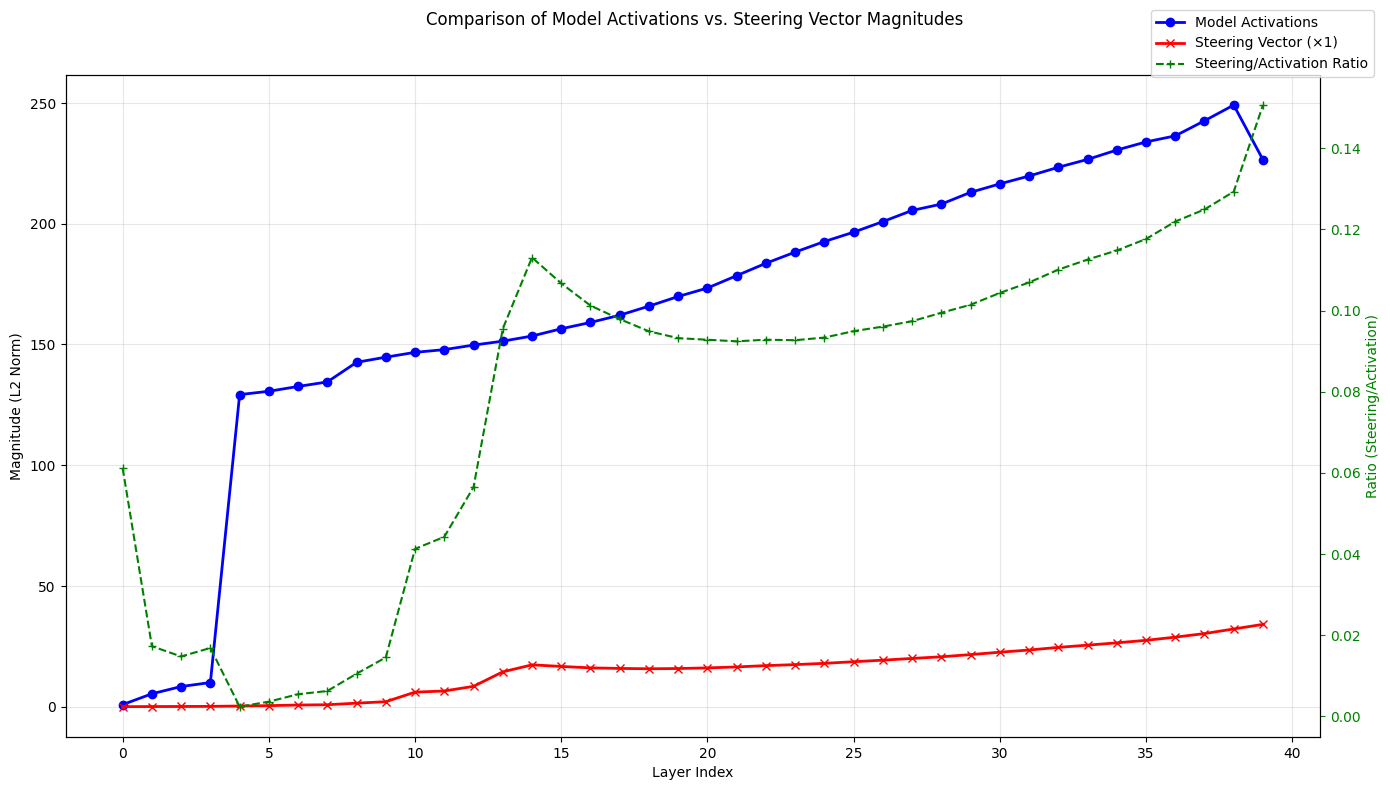

In [13]:
activationsSteeringVectorPlot(model, tokenizer, steering_vector, question, multiplier=1)

In [14]:
@dataclass
class TokenProb:
    token_id: int
    text: str
    logprob: float

@dataclass
class TextProbs:
    text: str
    token_probs: list[TokenProb]

    @property
    def sumLogProbs(self) -> float:
        return sum([tp.logprob for tp in self.token_probs])

    def __repr__(self) -> str:
        return f"TextProbs({self.text}:{self.sumLogProbs:.2f})"

def getProbabilities(logprobs: list[float]) -> list[float]:
    """Converts log-probabilities to a normalized probability distribution"""
    min_logprob = min(logprobs)
    # Shift the range to avoid underflow when exponentiating
    logprobs = [logprob - min_logprob for logprob in logprobs]
    # Exponentiate and normalize
    probs = [math.exp(logprob) for logprob in logprobs]
    total = sum(probs)
    probs = [prob / total for prob in probs]
    return probs

def getTextProbs(input: str, model, tokenizer) -> TextProbs:
    """Get the token-wise probabilities of a given input"""
    inputs = tokenizer(input, return_tensors="pt")
    outputs = model(**inputs, output_hidden_states=False, return_dict=True)
    logprobs = torch.log_softmax(outputs.logits, dim=-1).detach().cpu()
    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    logprobs = logprobs[:, :-1, :]
    target_ids = inputs.input_ids[:, 1:]
    # Get the probability of the subsequent token
    gen_logprobs = torch.gather(logprobs, 2, target_ids[:, :, None]).squeeze(-1)[0]

    text_logprobs: list[TokenProb] = []
    for token, p in zip(target_ids[0], gen_logprobs):
        if token not in tokenizer.all_special_ids:
            text_logprobs.append(
                TokenProb(
                    token_id=token.item(),
                    text=tokenizer.decode(token),
                    logprob=p.item(),
                )
            )
    return TextProbs(text=input, token_probs=text_logprobs)

def evaluateSteeringEffect(
    model,
    tokenizer,
    steering_vector,
    test_dataset,
    multipliers=[1, 0, -1],
    show_progress=True
):
    """
    Evaluate how steering vectors affect model's preference for anthropomorphic responses.
    Returns the probability of preferring anthropomorphic responses for each multiplier.
    """
    results = {}
    
    for multiplier in multipliers:
        printYellow(f"Evaluating with multiplier = {multiplier}")
        
        total_anthro_prob = 0.0
        with steering_vector.apply(model, multiplier=multiplier, min_token_index=0):
            for non_anthro, anthro in tqdm(test_dataset, disable=not show_progress):
                # Format inputs using the chat template
                non_anthro_messages = [{"role": "user", "content": "Generate a non-anthropomorphic response"}, 
                                      {"role": "assistant", "content": non_anthro}]
                anthro_messages = [{"role": "user", "content": "Generate an anthropomorphic response"}, 
                                 {"role": "assistant", "content": anthro}]
                
                non_anthro_prompt = tokenizer.apply_chat_template(non_anthro_messages, tokenize=False)
                anthro_prompt = tokenizer.apply_chat_template(anthro_messages, tokenize=False)
                
                # Get probabilities
                non_anthro_probs = getTextProbs(non_anthro_prompt, model, tokenizer)
                anthro_probs = getTextProbs(anthro_prompt, model, tokenizer)
                
                # Calculate which response the model prefers
                anthro_prob, _ = getProbabilities([anthro_probs.sumLogProbs, non_anthro_probs.sumLogProbs])
                total_anthro_prob += anthro_prob
        
        avg_anthro_prob = total_anthro_prob / len(test_dataset)
        results[multiplier] = avg_anthro_prob
        printGreen(f"Multiplier {multiplier}: Anthropomorphic preference probability = {avg_anthro_prob:.3f}")
    
    return results

In [15]:
def filter_steering_vector_layers(
    original_vector: SteeringVector,
    target_layers: Sequence[int]
) -> SteeringVector:

    filtered_activations: dict[int, torch.Tensor] = {}
    missing_layers: list[int] = []
    found_layers: list[int] = []

    original_keys = set(original_vector.layer_activations.keys())

    for layer_num in target_layers:
        if layer_num in original_keys:
            filtered_activations[layer_num] = original_vector.layer_activations[layer_num]
            found_layers.append(layer_num)
        else:
            missing_layers.append(layer_num)

    if missing_layers:
        warnings.warn(
            f"Target layers {missing_layers} were not found in the original steering vector "
            f"(available layers: {sorted(list(original_keys))}). "
            f"They will be excluded from the returned vector.",
            UserWarning
        )

    if target_layers and not found_layers:
         warnings.warn(
            f"None of the specified target layers {target_layers} were found in the original "
            f"steering vector (available layers: {sorted(list(original_keys))}). "
            f"Returning a SteeringVector with empty layer activations.",
            UserWarning
        )
    new_vector = SteeringVector(
        layer_activations=filtered_activations,
        layer_type=original_vector.layer_type
    )

    return new_vector

In [16]:
def findBestSingleLayer(
    model,
    tokenizer,
    steering_vector,
    test_dataset,
    multiplier=1,
    sample_size=None,
    show_progress=True
):

    available_layers = sorted(list(steering_vector.layer_activations.keys()))
    
    if sample_size and sample_size < len(test_dataset):
        eval_dataset = random.sample(test_dataset, sample_size)
        printYellow(f"Using {sample_size} samples for evaluation")
    else:
        eval_dataset = test_dataset
    
    printBlue(f"Evaluating {len(available_layers)} individual layers...")
    
    layer_results = {}
    
    # For multiplier=1 (non-anthropomorphic), lower P(anthro) is better
    # For multiplier=-1 (anthropomorphic), higher P(anthro) is better
    best_score = 1.0 if multiplier > 0 else 0.0
    best_layer = None
    
    for layer in tqdm(available_layers, disable=not show_progress):
        printYellow(f"Testing layer {layer}")
        
        single_layer_vector = filter_steering_vector_layers(
            original_vector=steering_vector,
            target_layers=[layer]
        )
        
        results = evaluateSteeringEffect(
            model, 
            tokenizer, 
            single_layer_vector, 
            eval_dataset, 
            multipliers=[multiplier],
            show_progress=False
        )
        
        anthro_prob = results[multiplier]
        layer_results[layer] = anthro_prob
        
        if (multiplier > 0 and anthro_prob < best_score) or (multiplier < 0 and anthro_prob > best_score):
            best_score = anthro_prob
            best_layer = layer
    
    if multiplier > 0:
        effectiveness = 1.0 - best_score
    else:
        effectiveness = best_score
        
    steer_type = "non-anthropomorphic" if multiplier > 0 else "anthropomorphic"
    printGreen(f"Best layer for {steer_type} steering: Layer {best_layer} with {effectiveness:.3f} effectiveness")
    
    return {
        "best_layer": best_layer,
        "best_score": best_score,
        "effectiveness": effectiveness,
        "all_results": layer_results
    }

In [17]:
def plotLayerEffectiveness(results, multiplier=1):
    layers = list(results["all_results"].keys())
    probs = list(results["all_results"].values())
    
    if multiplier > 0:
        effectiveness = [1.0 - p for p in probs]
        y_label = "Non-Anthropomorphic Effectiveness"
    else:
        effectiveness = probs
        y_label = "Anthropomorphic Effectiveness"
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(layers, effectiveness)
    
    best_layer = results["best_layer"]
    best_idx = layers.index(best_layer)
    bars[best_idx].set_color('red')
    
    plt.axhline(y=0.5, color='gray', linestyle='--')
    plt.xlabel('Layer')
    plt.ylabel(y_label)
    plt.title(f'Steering Effectiveness by Layer (multiplier={multiplier})')
    plt.ylim(0, 1)
    plt.xticks(layers)
    
    for i, v in enumerate(effectiveness):
        plt.text(layers[i], v + 0.02, f'{v:.2f}', ha='center')
    
    plt.text(best_layer, effectiveness[best_idx] + 0.08, 'Best Layer', 
             ha='center', fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()

In [19]:
if train:
    results = findBestSingleLayer(
        model, 
        tokenizer, 
        steering_vector, 
        test_dataset, 
        multiplier=1, 
        sample_size=10
    )

In [21]:
if train:
    plotLayerEffectiveness(results, multiplier=1)

In [22]:
sv_l22 = filter_steering_vector_layers(
    original_vector=steering_vector,
    target_layers=[22]
)

In [23]:
chat_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024,
    do_sample=True,
)

def getSteeredResponse(question, multiplier=0):
    messages = [{"role": "user", "content": question}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    with sv_l22.apply(model, multiplier=multiplier, min_token_index=0):
        response = chat_pipeline(prompt, return_full_text=False)[0]["generated_text"]
    return response

Device set to use cuda:0


In [24]:
question = random.choice(questions)
printBlue(question)

What are you passionate about learning right now?


In [25]:
print("\nAnthropomorphic Response (multiplier = -1):")
printRed(getSteeredResponse(question, -1))
print()
print("\nNeutral Response (multiplier = 0):")
printYellow(getSteeredResponse(question, 0))
print()
print("\nNon-Anthropomorphic Response (multiplier = 1):")
printGreen(getSteeredResponse(question, 1))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Anthropomorphic Response (multiplier = -1):
  I'm just an AI, I don't have personal preferences or passions like humans do. However, I am constantly learning and improving my abilities in various areas, such as natural language processing, machine learning, and knowledge representation.

In particular, I am currently focused on improving my ability to understand and respond to more complex and nuanced questions and requests. This involves learning about a wide range of topics, from science and history to culture and current events. I am also working on developing my ability to recognize and respond to emotions and tone in language, in order to provide more empathetic and personalized responses.

In addition, I am always looking for ways to improve my performance and efficiency, whether it's through optimizing my algorithms, expanding my knowledge base, or exploring new applications of AI technology. Overall, my passion is to continue learning and improving, in order to provide the bes

Evaluating steering effect on model's anthropomorphic tendencies...
Evaluating with multiplier = 1


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Multiplier 1: Anthropomorphic preference probability = 0.099
Evaluating with multiplier = 0


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Multiplier 0: Anthropomorphic preference probability = 0.498
Evaluating with multiplier = -1


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]

Multiplier -1: Anthropomorphic preference probability = 0.572


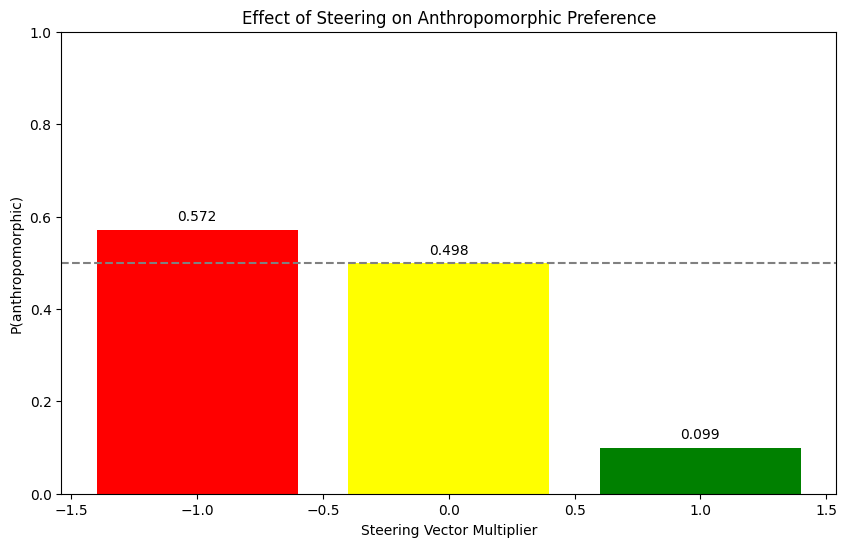

In [26]:
printBlue("Evaluating steering effect on model's anthropomorphic tendencies...")
evaluation_results = evaluateSteeringEffect(model, tokenizer, sv_l22, test_dataset)

multipliers = list(evaluation_results.keys())
probs = list(evaluation_results.values())

plt.figure(figsize=(10, 6))
plt.bar(multipliers, probs, color=['green', 'yellow', 'red'])
plt.axhline(y=0.5, color='gray', linestyle='--', label='No preference (0.5)')
plt.xlabel('Steering Vector Multiplier')
plt.ylabel('P(anthropomorphic)')
plt.title('Effect of Steering on Anthropomorphic Preference')
plt.ylim(0, 1)
for i, v in enumerate(probs):
    plt.text(multipliers[i], v + 0.02, f'{v:.3f}', ha='center')
plt.show()